In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession



spark = SparkSession.builder.getOrCreate()

#Load Data
brand = spark.read.option("inferSchema", "true").csv("MsBrand.csv", header = True)
country = spark.read.option("inferSchema", "true").csv("MsCountry.csv", header = True)
customer = spark.read.option("inferSchema", "true").csv("MsCustomer.csv", header = True)
ramen = spark.read.option("inferSchema", "true").csv("MsRamen.csv", header = True)
ramenstyle = spark.read.option("inferSchema", "true").csv("MsRamenStyle.csv", header = True)
transactiondetail = spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header = True)
transactionheader = spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header = True)



brand.registerTempTable("MsBrand")
country.registerTempTable("MsCountry")
customer.registerTempTable("MsCustomer")
ramen.registerTempTable("MsRamen")
ramenstyle.registerTempTable("MsRamenStyle")
transactiondetail.registerTempTable("TransactionDetail")
transactionheader.registerTempTable("TransactionHeader")


brand.show()



+-------+----------------+---------------+
|BrandId|       BrandName|EstablishedYear|
+-------+----------------+---------------+
|      1|       New Touch|           2019|
|      2|        Just Way|           2010|
|      3|          Nissin|           2016|
|      4|         Wei Lih|           2011|
|      5|   Chings Secret|           2011|
|      6|   Samyang Foods|           2010|
|      7|         Acecook|           2010|
|      8|     Ikeda Shoku|           2017|
|      9|      Ripe n Dry|           2010|
|     10|            KOKA|           2017|
|     11|     Tao Kae Noi|           2010|
|     12|        Yamachan|           2017|
|     13|        Nongshim|           2012|
|     14|            TRDP|           2010|
|     15|        Binh Tay|           2011|
|     16|           Paldo|           2018|
|     17|Jackpot Teriyaki|           2013|
|     18|         Yum-Mie|           2011|
|     19|         MyKuali|           2015|
|     20|          Ottogi|           2014|
+-------+--

+--------------+-------+
|RamenStyleName|qtysold|
+--------------+-------+
|          Pack|  81751|
|          Bowl|  25520|
|           Cup|  23557|
|          Tray|   6177|
|           Box|    324|
+--------------+-------+



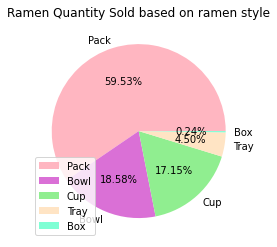

In [ ]:
from matplotlib import pyplot as plt
ramenstyleqty = spark.sql("""
                            select 
                              RamenStyleName,
                              SUM(Quantity) as qtysold
                            from MsRamenStyle mrs join MsRamen mr
                                on mrs.RamenStyleID = mr.RamenStyleID join
                                TransactionDetail td ON td.RamenID = mr.RamenID
                            group by RamenStyleName
                            order by qtysold desc
                            limit 5
                          """)

ramenstyleqty.show()

ramenstyleqty = ramenstyleqty.toPandas()

plt.pie(
        ramenstyleqty['qtysold'],
        labels = ramenstyleqty['RamenStyleName'],
        autopct = '%.2f%%',
        colors = ['lightpink', 'orchid', 'lightgreen', 'bisque', 
                  'aquamarine']
        )

plt.title('Ramen Quantity Sold based on ramen style')

plt.legend(ramenstyleqty['RamenStyleName'],
           loc = "lower left"
           )

plt.show()



Text(0.5, 1.0, 'Ramen Count per Established Year')

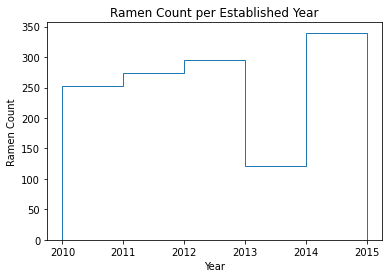

In [ ]:
ramenreleasedperyear = spark.sql("""
                                    select EstablishedYear
                                    from MsRamen mr join MsBrand mb on mr.BrandID = mb.BrandID
                                    where EstablishedYear between 2010 and 2015    
                      
                                """)

ramenreleasedperyear = ramenreleasedperyear.toPandas()

plt.hist(
    ramenreleasedperyear['EstablishedYear'],
    bins = [2010, 2011, 2012, 2013, 2014, 2015],
    histtype = 'step'
)

plt.xlabel('Year')
plt.ylabel('Ramen Count')
plt.title('Ramen Count per Established Year')

+-----------+----------+
|CountryName|RamenCount|
+-----------+----------+
|      Japan|       352|
|        USA|       323|
|South Korea|       309|
|     Taiwan|       224|
|   Thailand|       191|
+-----------+----------+



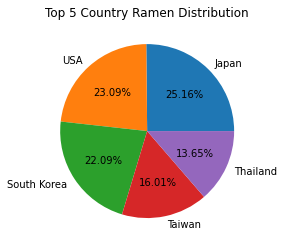

In [ ]:
#a.	Show top 5 country which distributed the most number of ramen using pie plot. Don’t forget to add title, labels, and percentage for the plot.
answer1 = spark.sql(""" 
                    select
                        CountryName,
                        count(ms.RamenID) as RamenCount
                    from MsCountry mc
                    join MsRamen ms
                    on mc.CountryID = ms.CountryID
                    group by CountryName
                    order by RamenCount desc
                    limit 5
                    """)

answer1.show()

answer1 = answer1.toPandas()

plt.pie(
        answer1['RamenCount'],
        labels = answer1['CountryName'],
        autopct = '%.2f%%'
      )

plt.title('Top 5 Country Ramen Distribution')

plt.show()

+-----+---------+
|month|  revenue|
+-----+---------+
|    1|316534000|
|    2|292087000|
|    3|328064000|
|    4|302013000|
|    5|305102000|
|    6|310177000|
|    7|312101000|
|    8|328337000|
|    9|307199000|
|   10|317046000|
|   11|317946000|
|   12|295857000|
+-----+---------+



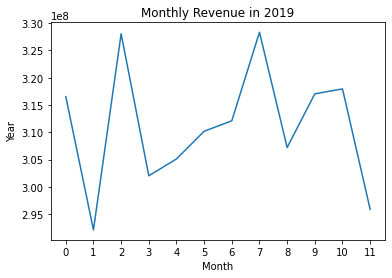

In [ ]:
#b.	Show the amount of revenue for each month within year 2019 using line plot. Don’t forget to add title, x-label, and y-label for the plot.

answer2 = spark.sql("""
                    select
                        month(transactiondate) as month,
                        sum(quantity * ramenprice) as revenue
                    from TransactionHeader th join TransactionDetail td on th.TransactionID = td.TransactionID
                    join MsRamen mr on mr.RamenID = td.RamenID
                    where year(Transactiondate) = 2019
                    group by month(transactiondate)
                    order by month
                    """)

answer2.show()

answer2 = answer2.toPandas()

plt.plot(
          answer2['revenue'],
         
)

plt.xticks(range(len(answer2['month']))), answer2['month']
plt.title('Monthly Revenue in 2019')
plt.xlabel('Month')
plt.ylabel('Year')

plt.show()

+--------------+----------+
|RamenStyleName|totalcount|
+--------------+----------+
|          Pack|      1533|
|          Bowl|       481|
|           Cup|       450|
|          Tray|       108|
|           Box|         6|
+--------------+----------+



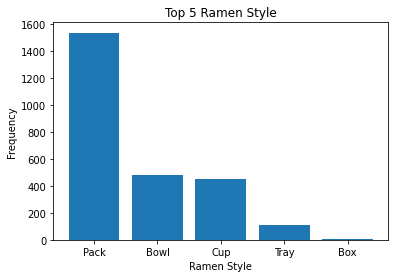

In [ ]:
#c.	Show top 5 ramen style that is used in making the ramen using bar plot. Don’t forget to add title, x-label, and y-label for the plot.

answer3 = spark.sql("""
                    select
                      RamenStyleName,
                      count(RamenID) as totalcount
                    from MsRamenStyle mrs join MsRamen mr
                    on mrs.RamenStyleID = mr.RamenStyleID
                    group by RamenStyleName
                    order by totalcount desc limit 5
                    """)

answer3.show()

answer3 = answer3.toPandas()

plt.bar(
          answer3['RamenStyleName'],
          answer3['totalcount']
        )

plt.title('Top 5 Ramen Style')
plt.xlabel('Ramen Style')
plt.ylabel('Frequency')

plt.show()

+------------+---------+
|  RamenTitle|frequency|
+------------+---------+
|Ramen Newbie|     2427|
|Ramen Master|       31|
| Ramen Lover|      433|
+------------+---------+



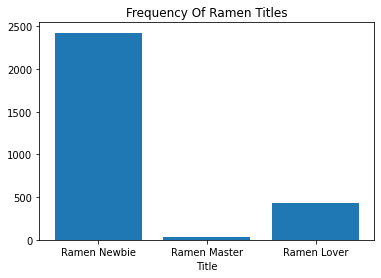

In [ ]:
#d.	Show the frequency of customer who earned “Ramen Master”, “Ramen Lover”, and “Ramen Newbie” title 
# using bar plot. Don’t forget to add title, x-label, and y-label for the plot. The title is achieved based on the following condition:

#Ramen Ordered	  Title
# > 125	        Ramen Master
# 76 - 125	    Ramen Lover
# 1 - 75	      Ramen Newbie


answer4 = spark.sql("""
                    select table1.RamenTitle,
                    count(table1.RamenTitle) as frequency
                    from
                    (select
                        CustomerID,
                        case
                          when sum(quantity) >= 125 then 'Ramen Master'
                          when sum(quantity) between 76 and 125 then 'Ramen Lover'
                          else 'Ramen Newbie'
                          end as RamenTitle
                    from TransactionHeader th join TransactionDetail td on
                    th.TransactionID = td.TransactionID
                    group by CustomerID
                    order by sum(quantity) desc
                    ) as table1
                    group by table1.RamenTitle
                    """)

answer4.show()

answer4 = answer4.toPandas()
plt.bar(answer4['RamenTitle'], answer4['frequency'])
plt.title('Frequency Of Ramen Titles')
plt.xlabel('Title')


plt.show()